# Investigating the house price on cottage

Imports and set magics:

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import re
from collections import defaultdict
from pathlib import Path
import csv
from lxml import html
import requests
import matplotlib.ticker as ticker



# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
from dataproject import NyboligAnalysis
from dataproject import NyBoligParser
from dataproject import HouseListingsScraper



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Scraping data

In this assignment we aim to analyse summer property listings from Nybolig (website: https://www.nybolig.dk/). We seek to investigate the relationship between location and price, identifying the most expensive places in Denmark and seeing if our results differ when using square meter price opposed to listing price. We also want to investigate the relationship between size and price of the listings. We expect that bigger sized listings will be listed at a higher price.

First, we need to scrape the data from the website. We regonize that this is not a part of the curriculum, but we thought of it as a creative way to achieve some data. The code below runs the scraper. If you want to run the scraper for other property types you can use the different keywords in the main function instead of "sommerhus":

**All**: ''
**Andelsbolig**: 'andelsbolig'
**Ejerlejlighed**: 'ejerlejlighed'
**Sommerhusgrunde**: 'fritidsgrund'
**Grunde**: 'helaarsgrund'
**Hus**: 'hus'
**Landejendomme**: 'landejendom'
**Rækkehuse**:  'raekkehus'
**Sommerhuse**: 'sommerhus'
**Villalejligheder**:   'villalejlighed'

For example if you want to scrape houses you can replace:    

parser = NyBoligParser(scrape_page("**sommerhus**",i)) 

with     

parser = NyBoligParser(scrape_page("**hus**",i)).

for i in range(1,200): determines the amount of data scraped. In this case we scrape 199 pages.

Inside the website html we identify the specific element that contains information on property listings. The element has three "children" that contains relevant information: "*address*", "*mix*" and "*price*". We extract this information for each item on the website and get the following data:


In [130]:
def scrape_page(property_type,page_num):
    # Create a scraper for the given page
    scraper = HouseListingsScraper("https://www.nybolig.dk/til-salg", property_type="sommerhus", page_num=page_num)
    # Scrape listings data from the page
    return scraper.parse_listings()

def main():

    lst = []

    for i in range(1,200):
        parser = NyBoligParser(scrape_page("sommerhus",i))
        parser.parse_listings()
        lst.append(parser.data_to_df())

    df = pd.concat(lst)

    df.to_csv('output.csv', index=False)
main()
df = pd.read_csv('raw_output.csv')
df.head()


https://www.nybolig.dk/til-salg/sommerhus?page=1
https://www.nybolig.dk/til-salg/sommerhus?page=2
https://www.nybolig.dk/til-salg/sommerhus?page=3
https://www.nybolig.dk/til-salg/sommerhus?page=4
https://www.nybolig.dk/til-salg/sommerhus?page=5
https://www.nybolig.dk/til-salg/sommerhus?page=6
https://www.nybolig.dk/til-salg/sommerhus?page=7
https://www.nybolig.dk/til-salg/sommerhus?page=8
https://www.nybolig.dk/til-salg/sommerhus?page=9
https://www.nybolig.dk/til-salg/sommerhus?page=10
https://www.nybolig.dk/til-salg/sommerhus?page=11
https://www.nybolig.dk/til-salg/sommerhus?page=12
https://www.nybolig.dk/til-salg/sommerhus?page=13
https://www.nybolig.dk/til-salg/sommerhus?page=14
https://www.nybolig.dk/til-salg/sommerhus?page=15
https://www.nybolig.dk/til-salg/sommerhus?page=16
https://www.nybolig.dk/til-salg/sommerhus?page=17
https://www.nybolig.dk/til-salg/sommerhus?page=18
https://www.nybolig.dk/til-salg/sommerhus?page=19
https://www.nybolig.dk/til-salg/sommerhus?page=20
https://w

,"Ballesvej 5, Sillerslev, 7990 Øster Assels",1.995.000,Fritidsbolig | 4 vær. | 97 m
0,"Drejet 36D, Spodsbj Drej, 5900 Rudkøbing",1.845.000,Fritidsbolig | 4 vær. | 83 m
1,"Engdraget 5, Hou, 9370 Hals",1.040.000,Fritidsbolig | 3 vær. | 93/76 m
2,"Hjelmvej 13, Elsegårde Strand",1.298.000,Fritidsbolig | 3 vær. | 40 m
3,"Baroniet 22, 3100 Hornbæk",4.195.000,Fritidsbolig | 4 vær. | 99 m
4,"Slunden 56, Rindby Strand, 6720 Fanø",2.495.000,Fritidsbolig | 5 vær. | 92 m


To make dataanalysis possible we need to parse this data. As you can see from the dataframe table the data is not very orginized nor very usable. We use the class NyBoligParser to parse the data. The code is a little bit complicated but it is essential to facilitate the analysis and thus it is still included in the assignment. 

**"address"**: To analyse listings accross the country we need to have variables for postal codes and cities. For this reason we extract postal code and city to variables representing these values. In the NyboligParser class we do this with the functions *"parse_city_name"* and *"parse_postal_code"*. We also store the full address as a point of reference for the listing. The *"parse_city_name"* function looks for the postal code and then saves everything after as the city name. The *"parse_postal_code"* function looks for the pattern r'\b\d{4}\b' which is a sequence of exactly four digits that are bounded by word boundaries. Word boundaries mean that the four digits should not be part of a larger sequence of digits, i.e., they should be preceded and followed by either a non-digit character or the start/end of the string. If it is successful in finding this it assigns the four digits as the postal code. 

**"price"**: The price "child"  is a little bit more straight forward. In the function *"parse_listing_elements"* we remove the periods in the prices and converts it to integers. This is convinient for the mathematical operations.

**"mix"**: Contains several varuable variables: Type of listing, number of rooms and the size of the listing. In the *"append_strucutal_data"* we start off by splitting into a list by spaces so for example the string 

"Fritidsbolig | 3 vær. | 93/76 m" 

will be converted to 

['Fritidsbolig', '|', '3', 'vær.', '|', '93/76', 'm']. 

We parse data[5] as information of the size of the listing and if "/" is included we split it into sq_m and sq_m2 corresponding to the size of the main building and the basement size respectively in integers. We also see that data[2] corresponds to the number of rooms so we parse this as integers and assign it to "rooms". Data[0] is assigned to "type". 

When parsing is completed we have a much more productive dataset for which we can analyse listings from the Nybolig website. The new dataset looks like this:

In [131]:
df = pd.read_csv('output.csv')
df.head()

,full_address,postal_code,city,price,type,rooms,sq_m,sq_m_cellar
0,"Ballesvej 5, Sillerslev, 7990 Øster Assels",7990.0,Øster Assels,1995000,Fritidsbolig,4,97,NaN
1,"Drejet 36D, Spodsbj Drej, 5900 Rudkøbing",5900.0,Rudkøbing,1845000,Fritidsbolig,4,83,NaN
2,"Engdraget 5, Hou, 9370 Hals",9370.0,Hals,1040000,Fritidsbolig,3,93,76.0
3,"Hjelmvej 13, Elsegårde Strand",NaN,Elsegårde Strand,1298000,Fritidsbolig,3,40,NaN
4,"Baroniet 22, 3100 Hornbæk",3100.0,Hornbæk,4195000,Fritidsbolig,4,99,NaN


# Analysis

In [132]:
file_path = 'output.csv'
analysis = NyboligAnalysis(file_path)

To make the analysis more accurate we need to remove outliers from the dataset. We can do this by using the remove_outliers functions from the NyboligAnalysis class. The remove_outliers() function takes three arguments: column_name, minimum number of city observations and a threshold. column_name specifies the name of the column that we want to remove outliers from, the second input removes cities that have below x number of observations and threshold specifies the number of standard deviations above or below the mean that we want to consider as outliers.

In [133]:
analysis.remove_outliers('rooms', 5, 15)
analysis.remove_outliers('sq_m', 5, 7)

We also want to remove listings in cities with less than 10 listings to make the analysis more robust. We do this with the following code:

In [134]:
analysis.remove_small_cities(min_observations=10)

**Descriptive statistics**

Change the list (lst) to perform descriptive statistics on variables of your choosing

In [135]:
lst = ['price', 'rooms', 'sq_m']

for i in lst:
    info = analysis.descriptive_statistics(i)
    print(info)
    print()


       count          mean           std  min        25%        50%  \
price   3552  2.381711e+06  2.389638e+06  100  1245000.0  1795000.0   

             75%       max  
price  2750000.0  49000000  

       count      mean       std  min  25%  50%  75%  max
rooms   3552  3.927083  1.288132    0  3.0  4.0  4.0   14

      count       mean        std  min   25%   50%    75%  max
sq_m   3552  91.443131  41.768267   16  64.0  82.0  109.0  401



The dataset consists of 4.099 property samples, providing information on price, number of rooms, and size (in square meters). For the property prices, the average value is approximately 2.329.591 with a standard deviation of 2,099,168. The minimum price is 520.000, and the maximum price is 32,500,000. The 25th percentile is 1,250,000, the median (50th percentile) is 1.795.000, and the 75th percentile is 2.696.500.

In terms of the number of rooms, the average is about 3,92 with a standard deviation of 1,26. The minimum number of rooms is 0, and the maximum is 14. The 25th percentile is 3, the median is 4, and the 75th percentile is also 4.

Regarding the size of the houses (size_1), the average value is 91,01 square meters with a standard deviation of 40,76. The smallest property has 9 square meters, and the largest property has 401 square meters. The 25th percentile is 64 square meters, the median is 82 square meters, and the 75th percentile is 108 square meters.

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     1101.
Date:                Wed, 24 May 2023   Prob (F-statistic):          1.41e-210
Time:                        11:33:47   Log-Likelihood:                -56727.
No. Observations:                3552   AIC:                         1.135e+05
Df Residuals:                    3550   BIC:                         1.135e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.64e+05   8.43e+04     -1.944      0.0

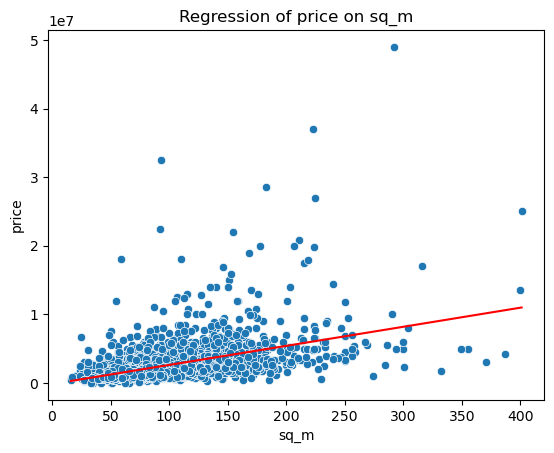

In [136]:
# Define the independent and dependent variables
X = analysis.data[['sq_m']]
y = analysis.data['price']

# Fit the OLS model and print the summary
summary = analysis.OLS(X, y)
print(summary)

# Plot the data with the regression line
analysis.plot_regression(X, y)

This OLS regression is performed on the house prices with size (size_1) as the independent variable. The model has an R-squared value of 0,221 and an adjusted R-squared value of 0.221, indicating that approximately 22,1% of the variation in house prices can be explained by the property size. 

The coefficient is 24.220 with a standard error of 710,15, and it is statistically significant (p-value < 0,001). This indicates that for each additional square meter, the house price increases by 24.220 kr. on average.


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     681.7
Date:                Wed, 24 May 2023   Prob (F-statistic):          1.27e-137
Time:                        11:33:49   Log-Likelihood:                -56895.
No. Observations:                3552   AIC:                         1.138e+05
Df Residuals:                    3550   BIC:                         1.138e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.424e+05   1.18e+05     -4.602      0.0

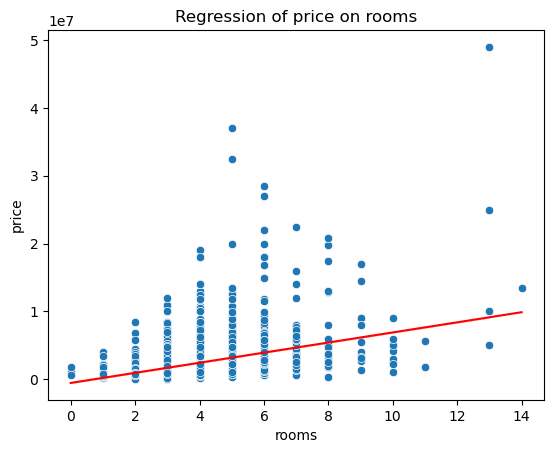

In [137]:
# Define the independent and dependent variables
X = analysis.data[['rooms']]
y = analysis.data['price']

# Fit the OLS model and print the summary
summary = analysis.OLS(X, y)
print(summary)

# Plot the data with the regression line
analysis.plot_regression(X, y)

This OLS regression is performed on the house prices with the number of rooms (rooms) as the independent variable. The model has an R-squared value of 0,132 and an adjusted R-squared value of 0,132, indicating that approximately 13,2% of the variation in house prices can be explained by the number of rooms.

The coefficient is 604.200 with a standard error of 24.200, and it is statistically significant (p-value < 0.001). This indicates that for each additional room, the house price increases by 604.200 kr. on average.


# How does location affect the price?

To see how the location impact the house price we will calculate the average house price of each city. With the intention of visualizing the locations with the cities with the highest prices to the lowest we are creating a bar chart.

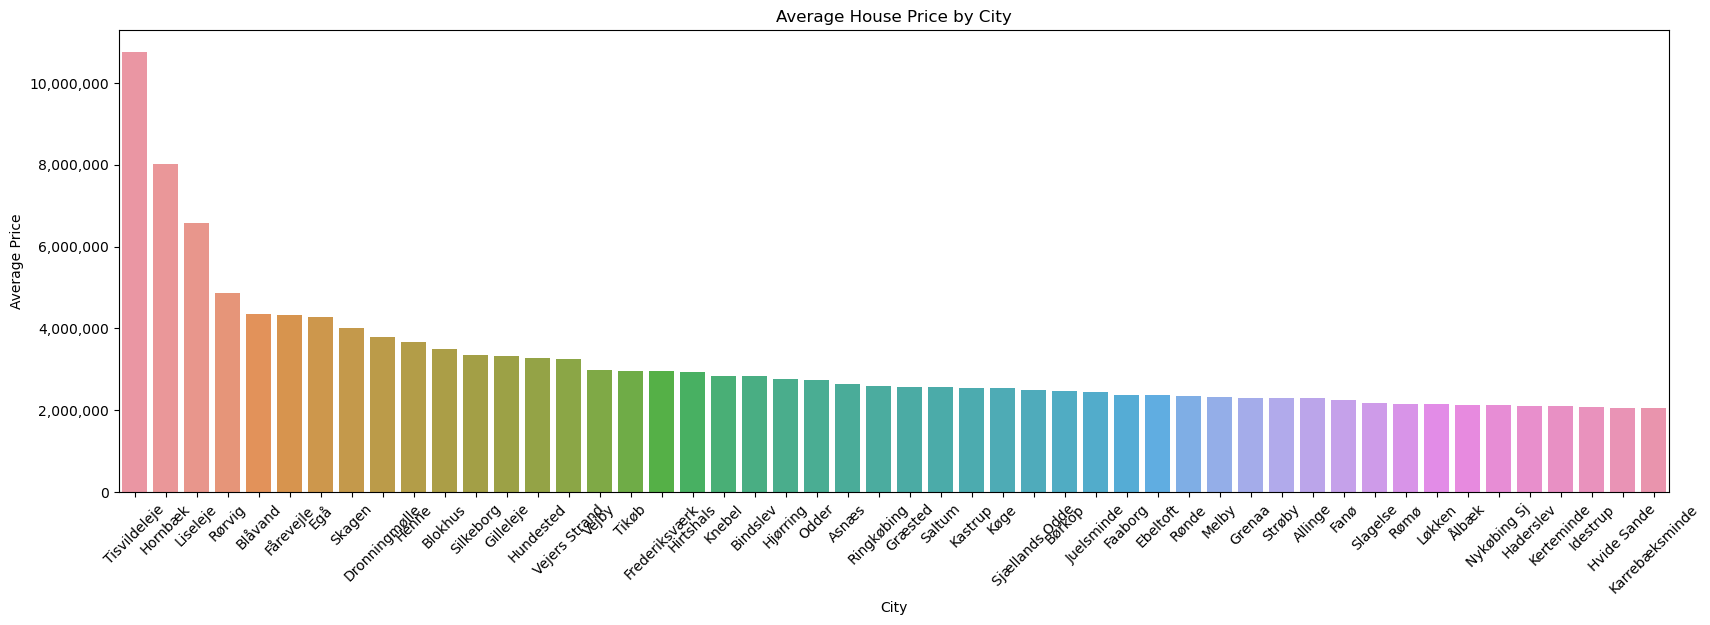

In [138]:
from matplotlib.ticker import FuncFormatter

# Group the data by city and calculate the mean price
mean_prices_by_city = analysis.data.groupby('city')['price'].mean().reset_index()
mean_prices_by_city = mean_prices_by_city.sort_values('price', ascending=False).head(50)

def price_formatter(x, _):
    return f'{int(x):,}'

formatter = FuncFormatter(price_formatter)

plt.figure(figsize=(20, 6))
ax = sns.barplot(x='city', y='price', data=mean_prices_by_city)
plt.title('Average House Price by City')
plt.xticks(rotation=45)
plt.ylabel('Average Price')
plt.xlabel('City')

ax.yaxis.set_major_formatter(formatter)
plt.show()


We can see from this that the location seems to have a big impact on the houses as the average house price in Tisvilde and Hornbæk is almost twice as high as the cities with the lowest prices.

# Comparing the highest and lowest price city

In [140]:
min_max_prices = analysis.min_max_city()
(min_price, min_city), (max_price, max_city) = min_max_prices
print(f"The lowest average price is {min_price:.2f} in {min_city}")
print(f"The highest average price is {max_price:.2f} in {max_city}")

The lowest average price is 781894.74 in Storvorde
The highest average price is 10753181.82 in Tisvildeleje


The lowest average price is 781894.74 in Storvorde
The highest average price is 10753181.82 in Tisvildeleje


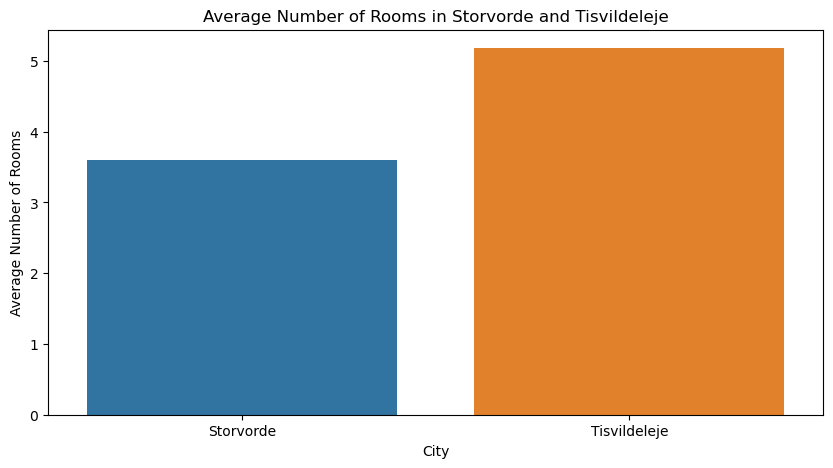

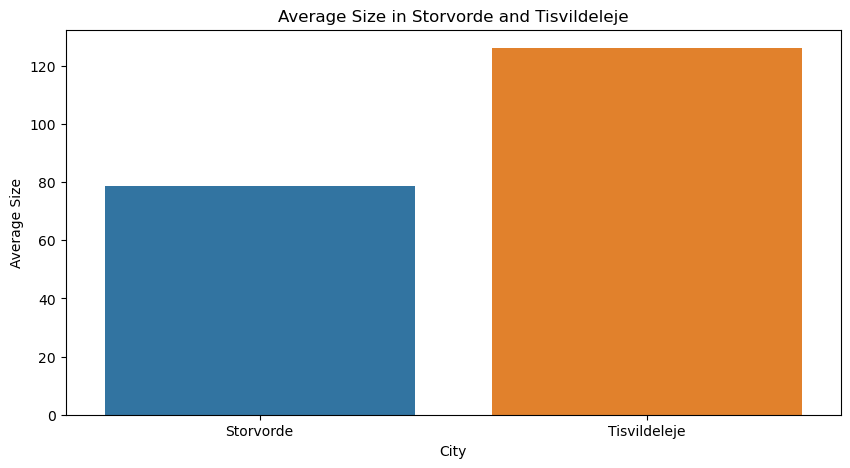

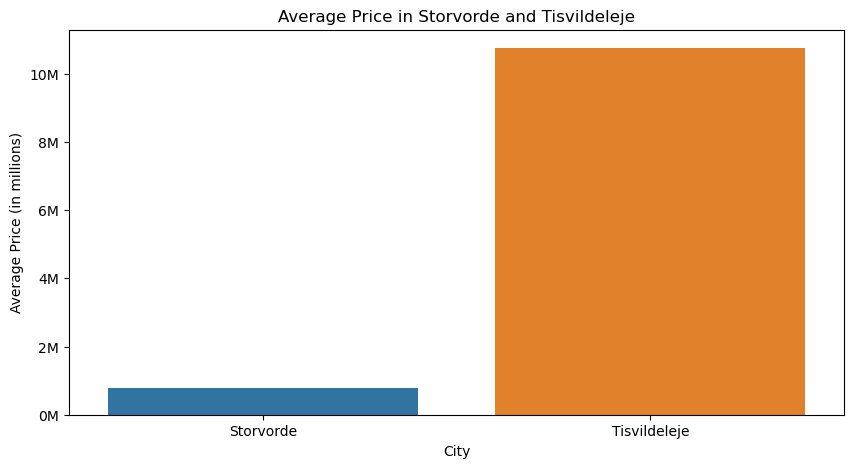

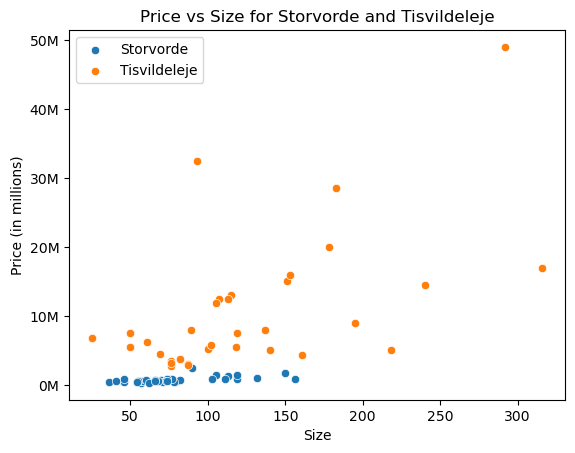

In [147]:
# Use the revised min_max_postcode method
min_max_prices = analysis.min_max_city()
(min_price, min_city), (max_price, max_city) = min_max_prices
print(f"The lowest average price is {min_price:.2f} in {min_city}")
print(f"The highest average price is {max_price:.2f} in {max_city}")

# Get the lowest and highest price cities
lowest_price_city = min_city
highest_price_city = max_city

# Filter the data to only include the lowest and highest price cities
lowest_price_data = analysis.data[analysis.data['city'] == lowest_price_city]
highest_price_data = analysis.data[analysis.data['city'] == highest_price_city]

# Average number of rooms comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=[min_city, max_city], y=[analysis.data[analysis.data['city']==min_city]['rooms'].mean(), analysis.data[analysis.data['city']==max_city]['rooms'].mean()])
plt.title(f'Average Number of Rooms in {min_city} and {max_city}')
plt.ylabel('Average Number of Rooms')
plt.xlabel('City')
plt.show()

# Size comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=[min_city, max_city], y=[analysis.data[analysis.data['city']==min_city]['sq_m'].mean(), analysis.data[analysis.data['city']==max_city]['sq_m'].mean()])
plt.title(f'Average Size in {min_city} and {max_city}')
plt.ylabel('Average Size')
plt.xlabel('City')
plt.show()

# Price comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=[min_city, max_city], y=[analysis.data[analysis.data['city']==min_city]['price'].mean(), analysis.data[analysis.data['city']==max_city]['price'].mean()])
plt.title(f'Average Price in {min_city} and {max_city}')
plt.ylabel('Average Price (in millions)')
plt.xlabel('City')

# Setting the y-axis format using a lambda function
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}M'.format(x*1e-6)))

plt.show()
#scatter
sns.scatterplot(x=lowest_price_data['sq_m'], y=lowest_price_data['price'], label=lowest_price_city)
sns.scatterplot(x=highest_price_data['sq_m'], y=highest_price_data['price'], label=highest_price_city)
plt.title(f"Price vs Size for {lowest_price_city} and {highest_price_city}")
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}M'.format(x*1e-6)))
plt.xlabel('Size')
plt.ylabel('Price (in millions)')
plt.legend()
plt.show()

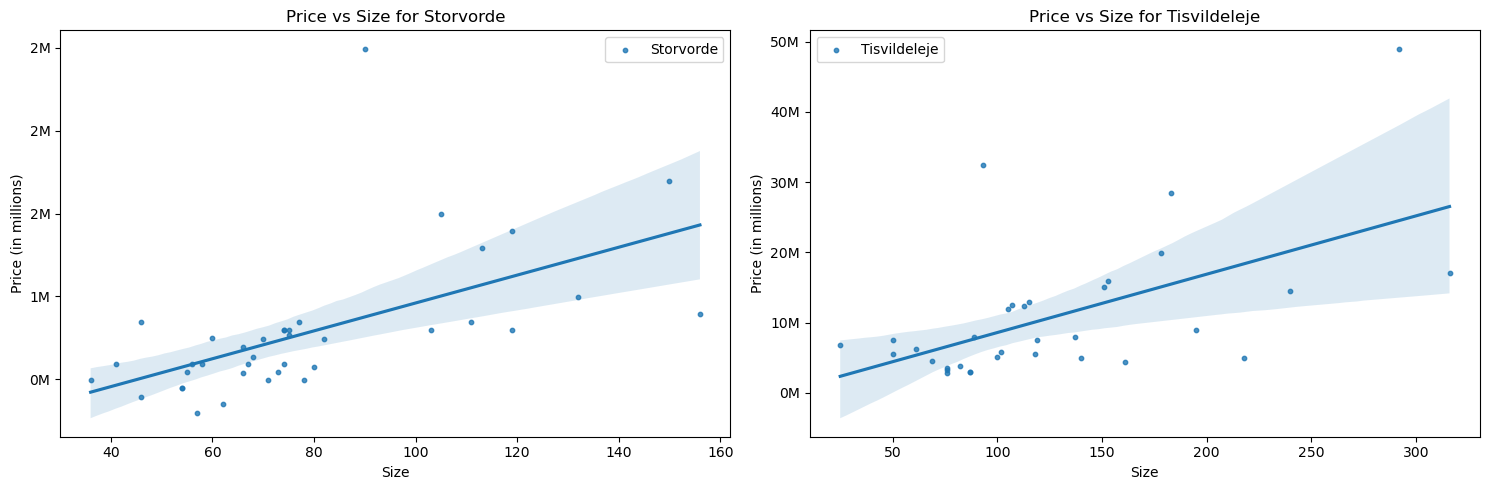

In [149]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5)) 

# Create a scatter plot for the city with the lowest average price
sns.regplot(x=lowest_price_data['sq_m'], y=lowest_price_data['price'], ax=axs[0], label=lowest_price_city, scatter_kws={'s': 10})
axs[0].set_title(f"Price vs Size for {lowest_price_city}")
axs[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}M'.format(x*1e-6)))
axs[0].set_xlabel('Size')
axs[0].set_ylabel('Price (in millions)')
axs[0].legend()

# Create a scatter plot for the city with the highest average price
sns.regplot(x=highest_price_data['sq_m'], y=highest_price_data['price'], ax=axs[1], label=highest_price_city, scatter_kws={'s': 10})
axs[1].set_title(f"Price vs Size for {highest_price_city}")
axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}M'.format(x*1e-6)))
axs[1].set_xlabel('Size')
axs[1].set_ylabel('Price (in millions)')
axs[1].legend()

# Display the figure with two subplots
plt.tight_layout()
plt.show()


These graphs shows that the average rooms and size in the houses in Tisvildeleje is higher than in Tarm supporting our OLS regression. 

In our OLS regression we saw that the size of the house is determined to have a positive impact on the price of the house. From our graph on average house prices we found the lowest and highest priced cities. To look further into this, we want to see if the average house size and rooms in the high price city is higher than the houses in low price city to support our results of the OLS regression. 

From this we see that the size of the house does not have a significant big impact on the price of the house in the low price city. On the other hand, the size of the house is considered to have a very significant impact on the price in Hornbæk. There can be several reasons for this. It may be a result of the interest in houses in the low price city is very low why the price may be generally low for all the houses no matter the size - this is not something we are going to investigate in this assignment, but it is something that would be interesting to look into in another context.

# Do the results change if we control for size?

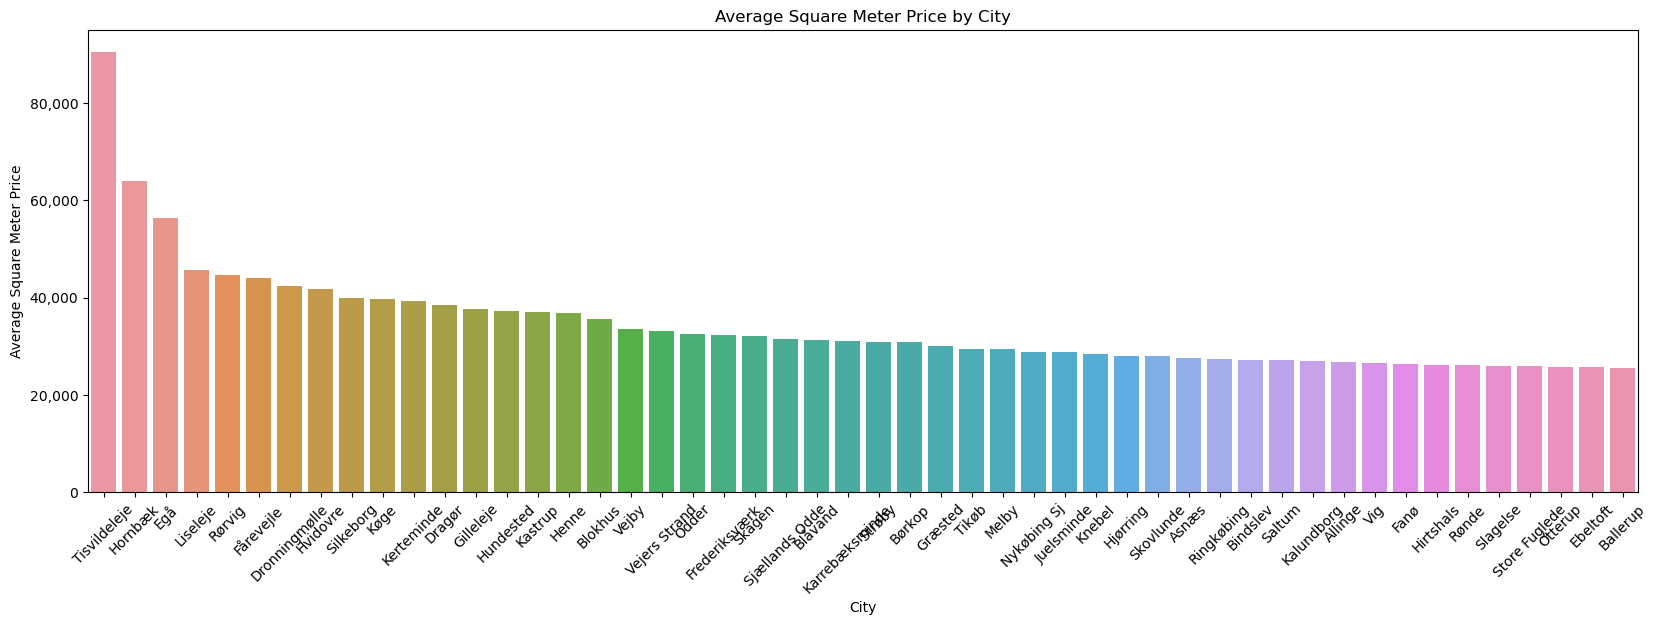

In [144]:
# Calculate the square meter price
analysis.data['square_meter_price'] = analysis.data['price'] / analysis.data['sq_m']

# Calculate the mean square meter price by city
mean_average_prices_by_city = analysis.data.groupby('city')['square_meter_price'].mean().reset_index()
mean_average_prices_by_city = mean_average_prices_by_city.sort_values('square_meter_price', ascending=False).head(50)
mean_average_prices_by_city['square_meter_price'] = mean_average_prices_by_city['square_meter_price'].astype(int)

# Plot the bar chart
plt.figure(figsize=(20, 6))
ax = sns.barplot(x='city', y='square_meter_price', data=mean_average_prices_by_city, order=mean_average_prices_by_city['city'])
plt.title('Average Square Meter Price by City')
plt.xticks(rotation=45)
plt.ylabel('Average Square Meter Price')
plt.xlabel('City')
ax.yaxis.set_major_formatter(formatter)
plt.show()



In [145]:
# Lowest Price cities
lowest_price_cities = analysis.data.groupby('city')['price'].mean().nsmallest(5).reset_index()['city'].tolist()
lowest_avg_price_cities = analysis.data.groupby('city')['square_meter_price'].mean().nsmallest(5).reset_index()['city'].tolist()
lowest_price_df = pd.DataFrame(lowest_price_cities, columns=['Lowest 5 Price Cities'])
lowest_avg_price_df = pd.DataFrame(lowest_avg_price_cities, columns=['Lowest 5 Average Square Meter Price Cities'])

# Highest Price cities
highest_price_cities = analysis.data.groupby('city')['price'].mean().nlargest(5).reset_index()['city'].tolist()
highest_avg_price_cities = analysis.data.groupby('city')['square_meter_price'].mean().nlargest(5).reset_index()['city'].tolist()
highest_price_df = pd.DataFrame(highest_price_cities, columns=['Highest 5 Price Cities'])
highest_avg_price_df = pd.DataFrame(highest_avg_price_cities, columns=['Highest 5 Average Square Meter Price Cities'])

# Concatenate the two dataframes
result_df = pd.concat([lowest_price_df, lowest_avg_price_df, highest_price_df, highest_avg_price_df], axis=1)
result_df


,Lowest 5 Price Cities,Lowest 5 Average Square Meter Price Cities,Highest 5 Price Cities,Highest 5 Average Square Meter Price Cities
0,Storvorde,Storvorde,Tisvildeleje,Tisvildeleje
1,Nakskov,Nakskov,Hornbæk,Hornbæk
2,Nibe,Roslev,Liseleje,Egå
3,Askø,Brovst,Rørvig,Liseleje
4,Skjern,Nimtofte,Blåvand,Rørvig


We see that the results change when we control for size. Tisvildeleje is relatively expensive in both aboslute price and square meter price.

In [156]:
categories = [
    "Lowest 5 Price Cities",
    "Lowest 5 Average Square Meter Price Cities",
    "Highest 5 Price Cities",
    "Highest 5 Average Square Meter Price Cities"
]

for category in categories:
    # Get the list of cities for the current category
    cities = result_df[category].tolist()

    # Filter the data for the current cities
    city_data = analysis.data[analysis.data['city'].isin(cities)]

    # Run the regression for price on size
    results = analysis.OLS(city_data['sq_m'], city_data['price'])

    # Print the results
    print(f"Results for {category}:")
    print(results)   # Change made here
    print("\n")


Results for Lowest 5 Price Cities:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     17.61
Date:                Wed, 24 May 2023   Prob (F-statistic):           6.36e-05
Time:                        14:53:53   Log-Likelihood:                -1314.4
No. Observations:                  92   AIC:                             2633.
Df Residuals:                      90   BIC:                             2638.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.991